# Demonstration of `numpyro-oop` usage



In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpyro
import numpyro.distributions as dist
from numpyro.diagnostics import hpdi
import arviz as az

from numpyro_oop import BaseNumpyroModel

/Users/tsawallis/.local/share/virtualenvs/numpyro-oop-h_Ko2lEj/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Basic regression example

In [2]:
# example from https://num.pyro.ai/en/stable/tutorials/bayesian_regression.html

DATASET_URL = "https://raw.githubusercontent.com/rmcelreath/rethinking/master/data/WaffleDivorce.csv"
dset = pd.read_csv(DATASET_URL, sep=";")
dset.head()

,Location,Loc,Population,MedianAgeMarriage,Marriage,Marriage SE,Divorce,Divorce SE,WaffleHouses,South,Slaves1860,Population1860,PropSlaves1860
0,Alabama,AL,4.78,25.3,20.2,1.27,12.7,0.79,128,1,435080,964201,0.45
1,Alaska,AK,0.71,25.2,26.0,2.93,12.5,2.05,0,0,0,0,0.00
2,Arizona,AZ,6.33,25.8,20.3,0.98,10.8,0.74,18,0,0,0,0.00
3,Arkansas,AR,2.92,24.3,26.4,1.70,13.5,1.22,41,1,111115,435450,0.26
4,California,CA,37.25,26.8,19.1,0.39,8.0,0.24,0,0,0,379994,0.00


In [3]:
def standardize(x):
    return (x - x.mean()) / x.std()


dset["AgeScaled"] = dset.MedianAgeMarriage.pipe(standardize)
dset["MarriageScaled"] = dset.Marriage.pipe(standardize)
dset["DivorceScaled"] = dset.Divorce.pipe(standardize)

### Defining the model class

The basic idea of `numpyro-oop` is that the user should define a new class that inherits from `BaseNumpyroModel`. 
This new class mainly needs to define the `model` method.
Then all other sampling and prediction steps are handled by `numpyro-oop`, or related libraries (e.g. `arviz`).

Here's a demonstration of a basic `RegressionModel` class plus `model` definition for the data above.
See the [numpyro demo here](https://num.pyro.ai/en/stable/tutorials/bayesian_regression.html) for more.

In [4]:
class RegressionModel(BaseNumpyroModel):
    def model(self, data=None):
        a = numpyro.sample("a", dist.Normal(0.0, 0.2))
        bM = numpyro.sample("bM", dist.Normal(0.0, 0.5))
        M = bM * data.MarriageScaled.values
        sigma = numpyro.sample("sigma", dist.Exponential(1.0))
        mu = numpyro.deterministic("mu", a + M)
        numpyro.sample("obs", dist.Normal(mu, sigma), obs=data.DivorceScaled.values)

We can now instantiate this class, adding the dataset and a random seed.


In [5]:
m1 = RegressionModel(data=dset, seed=42)

We can also render a graphical representation of our model (requires `graphviz` package).

In [6]:
m1_graph = m1.render()

Now sample from the model (using the NUTS sampler, by default):

In [7]:
m1.sample()

/Users/tsawallis/HESSENBOX-DA/tsawallis/Projects/numpyro-oop/numpyro_oop/core.py:133: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  self.mcmc = MCMC(
sample: 100%|██████████| 2000/2000 [00:01<00:00, 1719.32it/s, 3 steps of size 8.94e-01. acc. prob=0.90]


In [8]:
m1.mcmc.print_summary(0.90)


                mean       std    median      5.0%     95.0%     n_eff     r_hat
         a      0.00      0.11      0.01     -0.17      0.19   4029.47      1.00
        bM      0.35      0.13      0.35      0.13      0.55   3909.32      1.00
     sigma      0.95      0.10      0.94      0.77      1.09   3576.33      1.00

Number of divergences: 0


In [9]:
# pred_data = pd.DataFrame({"MarriageScaled": np.linspace(-2, 2, 50)})
preds = m1.predict()
post_pred_mean = preds["mu"].mean(axis=0)
post_pred_hpdi = hpdi(preds["mu"], 0.9)
dset["post_mean"] = post_pred_mean
dset["post_lower"] = post_pred_hpdi[0]
dset["post_upper"] = post_pred_hpdi[1]

/Users/tsawallis/HESSENBOX-DA/tsawallis/Projects/numpyro-oop/numpyro_oop/core.py:185: UserWarning: Sample's batch dimension size 4000 is different from the provided 200 num_samples argument. Defaulting to 4000.
  predictive = Predictive(


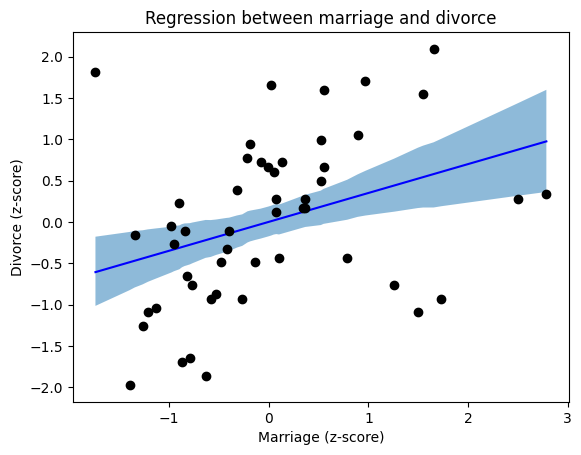

In [10]:
sorted_dset = dset.copy().sort_values(by=["MarriageScaled"])

fig, ax = plt.subplots()
ax.plot(sorted_dset["MarriageScaled"], sorted_dset["post_mean"], "b-")
ax.fill_between(
    sorted_dset["MarriageScaled"],
    y1=sorted_dset["post_lower"],
    y2=sorted_dset["post_upper"],
    alpha=0.5,
)
ax.plot(sorted_dset["MarriageScaled"], sorted_dset["DivorceScaled"], "ko")
ax.set_xlabel("Marriage (z-score)")
ax.set_ylabel("Divorce (z-score)")
ax.set_title("Regression between marriage and divorce")
plt.show()

## Hierarchical inference example: Eight schools

Here we use the popular Eight schools dataset to demonstrate the implementation of a hierarchical model and the use of plates with `numpyro-oop`.
The reference implementation in the `numpyro` docs is here: https://num.pyro.ai/en/stable/getting_started.html#a-simple-example-8-schools

The dataset was collected by Alderman and Powers (1979) and reported in Rubin (1981).
It was described by Sturtz et al (2005):

> The Scholastic Aptitude Test (SAT) measures the aptitude of high-schoolers in order to help colleges to make admissions decisions. It is divided into two parts, verbal (SAT-V) and mathematical (SAT-M). Our data comes from the SAT-V (Scholastic Aptitude Test-Verbal) on eight different high schools, from an experiment conducted in the late 1970s. SAT-V is a standard multiple choice test administered by the Educational Testing Service. This Service was interested in the effects of coaching programs for each of the selected schools.
>
> The study included coached and uncoached pupils, about sixty in each of the eight different schools; see Rubin (1981). All of them had already taken the PSAT (Preliminary SAT) which results were used as covariates. For each school, the estimated treatment effect and the standard error of the effect estimate are given. These are calculated by an analysis of covariance adjustment appropriate for a completely randomized experiment (Rubin 1981). This example was analyzed using a hierarchical normal model in Rubin (1981) and Gelman, Carlin, Stern, and Rubin (2003, Section 5.5).

#### References

Alderman, D., & Powers, D. (1979). The effects of special preparation on SAT-Verbal scores. Research Report 79–1. Educational Testing Service, Princeton, N.J.

Rubin, D. B. (1981). Estimation in Parallel Randomized Experiments. *Journal of Educational Statistics, 6*(4), 377–400.

Sturtz, S., Ligges, U., & Gelman, A. (2005). R2WinBUGS: A Package for Running WinBUGS from R. Journal of Statistical Software, 12(3). https://doi.org/10.18637/jss.v012.i03


In [11]:
df = pd.DataFrame(
    {
        "school": ["A", "B", "C", "D", "E", "F", "G", "H"],
        "treatment_effect": [28.39, 7.94, -2.75, 6.82, -0.64, 0.63, 18.01, 12.16],
        "treatment_sd": [14.9, 10.2, 16.3, 11.0, 9.4, 11.4, 10.4, 17.6],
    }
)
df

,school,treatment_effect,treatment_sd
0,A,28.39,14.9
1,B,7.94,10.2
2,C,-2.75,16.3
3,D,6.82,11.0
4,E,-0.64,9.4
5,F,0.63,11.4
6,G,18.01,10.4
7,H,12.16,17.6


`numpyro-oop` allows us to specify grouping variables in the dataframe. 
Each grouping variable will be used to create a `numpyro.plate` object stored internally in the model class. 
The `model` definition can then use this plate object in the standard context.
The advantage here is that we can verify that dimensions and labels correspond.

To see how the plate structure will correspond to the variable school, let's call this first on the base class:

In [12]:
tmp = BaseNumpyroModel(seed=1, data=df, group_variables="school")
tmp.plate_dicts

{'school': {'coords': {0: 'A',
   1: 'B',
   2: 'C',
   3: 'D',
   4: 'E',
   5: 'F',
   6: 'G',
   7: 'H'},
  'dim': -1,
  'size': 8,
  'idx': array([0, 1, 2, 3, 4, 5, 6, 7], dtype=int8),
  'plate': <numpyro.primitives.plate at 0x12eec7c80>}}

We can then make use of this plate with the context `self.plate_dicts["school"]["plate"]` in the body of our model:

In [23]:
class EightSchools(BaseNumpyroModel):
    def model(self, data=None):
        y = data.treatment_effect.values
        sigma = data.treatment_sd.values
        mu = numpyro.sample("mu", dist.Normal(0, 5))
        tau = numpyro.sample("tau", dist.HalfCauchy(5))
        with self.plate_dicts["school"]["plate"]:
            theta = numpyro.sample("theta", dist.Normal(mu, tau))
        numpyro.sample(
            "obs", dist.Normal(theta[self.plate_dicts["school"]["idx"]], sigma), obs=y
        )  # could also include in the plate context; used to demo "idx" here.

Note that this is equivalent to writing 

```python
with numpyro.plate("school", size=8, dim=-1):
  ...
```

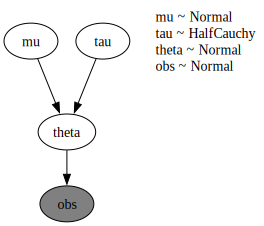

In [24]:
m2 = EightSchools(seed=258, data=df, group_variables="school")
m2.render()  # fails to render plate

Note that while the `numpyro-oop` plate wrapper (`self.plate_dicts["school"]["plate"]`) works for sampling (see below), it does cause problems with rendering the graphical model (no plate is shown).

In [25]:
m2.sample()
m2.mcmc.print_summary(0.9)

/Users/tsawallis/HESSENBOX-DA/tsawallis/Projects/numpyro-oop/numpyro_oop/core.py:133: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  self.mcmc = MCMC(
sample: 100%|██████████| 2000/2000 [00:01<00:00, 1692.16it/s, 15 steps of size 2.62e-01. acc. prob=0.63]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
        mu      4.53      3.25      4.70     -0.68      9.80    504.46      1.01
       tau      4.07      3.17      3.21      0.50      8.12    326.20      1.00
  theta[0]      6.66      5.96      6.20     -2.42     15.76    896.76      1.00
  theta[1]      5.11      4.80      5.18     -2.20     12.98    992.11      1.01
  theta[2]      4.06      5.49      4.41     -4.34     13.00   1075.68      1.01
  theta[3]      4.87      4.94      4.88     -2.73     13.15   1161.42      1.00
  theta[4]      3.69      4.87      4.11     -4.31     11.37    906.46      1.00
  theta[5]      4.01      5.07      4.46     -4.20     12.12   1089.90      1.00
  theta[6]      6.57      5.18      6.33     -1.50     15.04    848.84      1.01
  theta[7]      5.02      5.48      4.98     -3.77     13.85    996.11      1.01

Number of divergences: 78
